In [2]:
#ERT_Fine_Tuning_Sentence_Classification

In [4]:
import pandas as pd

In [5]:
df = pd.read_csv("in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df.shape

(8551, 4)

In [8]:
try:
  import transformers
except:
  print("Installing transformers")
  !pip -q install transformers

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification,get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image 

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
!nvidia-smi

Fri Jul  5 20:03:12 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 556.12                 Driver Version: 556.12         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060      WDDM  |   00000000:04:00.0  On |                  N/A |
|  0%   41C    P8             N/A /  115W |    7541MiB /   8188MiB |      6%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [11]:
import requests
from PIL import Image
from io import BytesIO

In [12]:
def get_image_from_github(image_name):
    base_url = 'https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-and-Computer-Vision-3rd-Edition/main/Notebook%20images/05/'

    # Make the request
    response = requests.get(base_url + image_name)

    # Check if the request was successful
    if response.status_code == 200:
        # Read the image
        image = Image.open(BytesIO(response.content))

        # Return the image
        return image
    else:
        print(f'Error {response.status_code}: Could not access the image file.')
        return None

In [13]:
!curl -L https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-and-Computer-Vision-3rd-Edition/master/Chapter05/in_domain_train.tsv --output "in_domain_train.tsv"
     

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  428k  100  428k    0     0   618k      0 --:--:-- --:--:-- --:--:--  620k


In [14]:
!curl -L https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-and-Computer-Vision-3rd-Edition/master/Chapter05/out_of_domain_dev.tsv --output "out_of_domain_dev.tsv"
     

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 33 28506   33  9597    0     0  17539      0  0:00:01 --:--:--  0:00:01 17609
100 28506  100 28506    0     0  51478      0 --:--:-- --:--:-- --:--:-- 51641


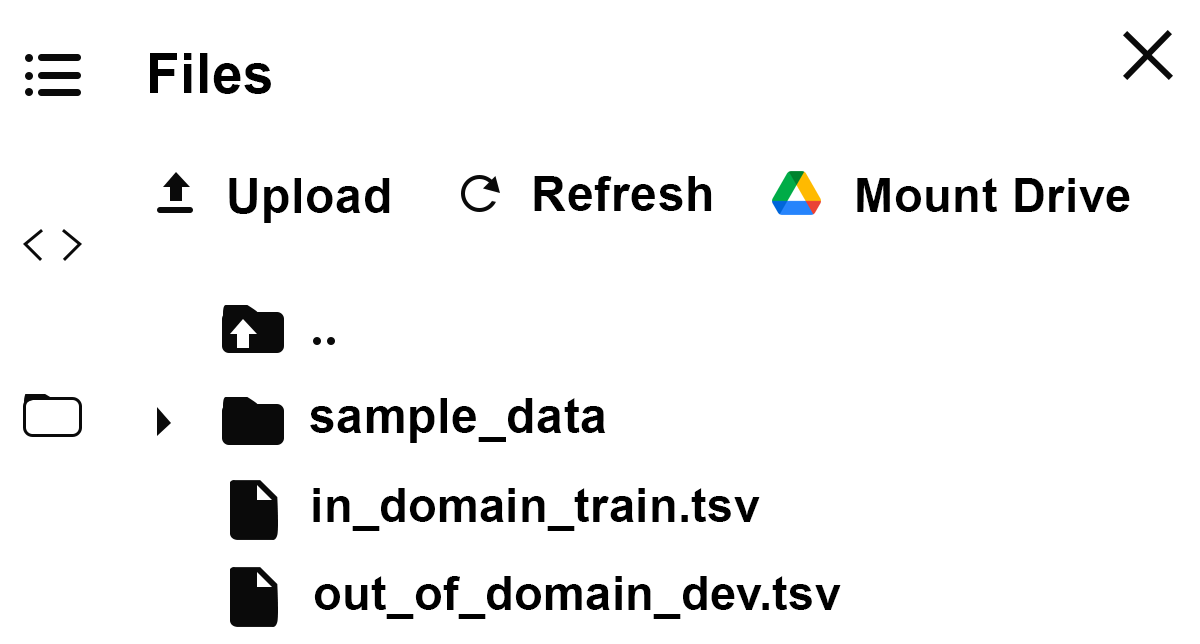

In [15]:
display(get_image_from_github('B19899_05_05.png') or print('Image not found'))

In [16]:

#source of dataset : https://nyu-mll.github.io/CoLA/
df = pd.read_csv("in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df.shape
     

(8551, 4)

In [17]:
df.sample(10)

,sentence_source,label,label_notes,sentence
6659,m_02,1,NaN,the cat trotted into the kitchen .
6860,m_02,1,NaN,she told him the whole story .
3652,ks08,1,NaN,john read the book loudly .
4842,ks08,1,NaN,whose car is blocking the entrance to the store ?
7131,sks13,0,*,this girl in the red coat one will put a pict...
3376,l-93,1,NaN,bill rolled the ball down the hill .
5075,ks08,1,NaN,we are using their teaching material .
4373,ks08,0,*,tom kicked not a ball .
6725,m_02,1,NaN,show me the folder in which you stored the doc...
412,bc01,0,*,a man to come is unlikely .


In [20]:

sentences = df.sentence.values


sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values